# Treinamento do Modelo de Machine Learning

**Objetivo:** Criar e treinar um modelo capaz de prever a Inadimplência Pessoa Física (`inad_pf_tot`).

**Etapas:**
1.  **Pré-processamento:** Divisão entre Treino (Passado) e Teste (Futuro).
2.  **Modelo Baseline:** Random Forest com variáveis macroeconômicas.
3.  **Modelo Otimizado:** Random Forest com Autoregressão (usando o mês anterior para prever o próximo).
4.  **Exportação:** Salvar o modelo campeão para o App (Streamlit).

In [1]:
# --- 1. Bibliotecas e Configuração ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from pathlib import Path

# Configuração visual
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Carregar dados
data_path = Path("../data/processed/df_modelagem.csv")
if data_path.exists():
    df = pd.read_csv(data_path, index_col="data", parse_dates=True)
    print(f"Dados carregados! Shape: {df.shape}")
else:
    print("ERRO: Arquivo df_modelagem.csv não encontrado. Rode o notebook anterior.")

Dados carregados! Shape: (120, 42)


In [2]:
# --- 2. Definição do Alvo e Limpeza ---

target = "inad_pf_tot"

# --- 3. Separação de Features e Alvo ---

# 1. Identifica todas as colunas que começam com 'inad_'
cols_leakage = [c for c in df.columns if c.startswith("inad_")]
print(f"Colunas de inadimplência encontradas (serão removidas do X): {cols_leakage}")

# 2. Separação X e y
X = df.drop(columns=cols_leakage)
y = df[target]

# 3. Tratamento de Variáveis Categóricas (Dummies)
X = pd.get_dummies(X, drop_first=True)

print(f"\nFeatures finais (X): {X.shape[1]} colunas")
print("Colunas restantes no X (Exemplo):", list(X.columns[:10]))
display(X.head(2))

Colunas de inadimplência encontradas (serão removidas do X): ['inad_pj_tot', 'inad_pf_tot', 'inad_rd_pf_cr_rur_tot', 'inad_rd_pj_cr_rur_tot']

Features finais (X): 38 colunas
Colunas restantes no X (Exemplo): ['ipca', 'spread_pf', 'spread_pj', 'spread_tot', 'selic', 'cdi', 'dolar_ptax', 'rendimento_medio_mensal_reais', 'tx_informalidade_p14m_ocupadas_pct', 'pessoas_14mais_mil']


,ipca,spread_pf,spread_pj,spread_tot,selic,cdi,dolar_ptax,rendimento_medio_mensal_reais,tx_informalidade_p14m_ocupadas_pct,pessoas_14mais_mil,...,tx_desocupacao_p14m_pct_lag_12,rendimento_medio_mensal_reais_lag_3,rendimento_medio_mensal_reais_lag_6,rendimento_medio_mensal_reais_lag_12,dolar_ptax_lag_3,dolar_ptax_lag_6,dolar_ptax_lag_12,mes,trimestre,flag_safra
data,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.75,27.66,11.19,19.78,0.052531,0.052484,4.052350,1941.0,38.3,160845.0,...,8.0,1792.0,1792.0,1792.0,3.880138,3.223143,2.634229,1,1,0
2016-02-01,0.39,28.63,11.64,20.56,0.052531,0.052461,3.973742,1941.0,38.3,160845.0,...,8.0,1792.0,1792.0,1792.0,3.776460,3.514305,2.816450,2,1,1


# Divisão Temporal
Em dados temporais, não podemos embaralhar (*shuffle*) os dados. O modelo não pode ver o futuro (teste) para prever o passado (treino). Por isso cortamos cronologicamente:
- Treino: 80% mais antigo.
- Teste: 20% mais recente.

In [3]:
# --- 3. Divisão Treino/Teste (Time Series Split) ---

train_size = int(len(df) * 0.80)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Treino: {X_train.index.min().date()} até {X_train.index.max().date()} ({len(X_train)} meses)")
print(f"Teste:  {X_test.index.min().date()} até {X_test.index.max().date()} ({len(X_test)} meses)")

# --- 4. Padronização (StandardScaler) ---
# Importante para modelos sensíveis à escala, e ajuda o Random Forest a convergir melhor
scaler = StandardScaler()

# Ajustamos o scaler APENAS no treino para evitar vazamento de dados do teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Voltando para DataFrame (para manter nomes das colunas)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Treino: 2016-01-01 até 2023-12-01 (96 meses)
Teste:  2024-01-01 até 2025-12-01 (24 meses)


# Modelo Baseline (Random Forest)

Treinando Random Forest (Baseline)...
RMSE: 0.1928 | MAE: 0.1773 | R2: -5.6376


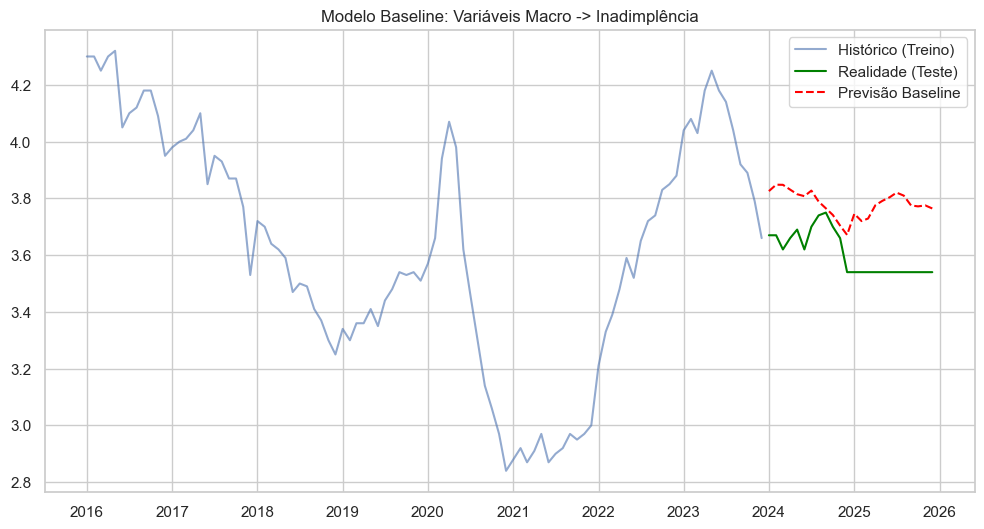

In [4]:
# --- 5. Treinamento Modelo Baseline ---
print("Treinando Random Forest (Baseline)...")

model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model_rf.fit(X_train_scaled, y_train)

# Previsão
y_pred = model_rf.predict(X_test_scaled)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Histórico (Treino)", alpha=0.6)
plt.plot(y_test.index, y_test, label="Realidade (Teste)", color="green")
plt.plot(y_test.index, y_pred, label="Previsão Baseline", color="red", linestyle="--")
plt.title("Modelo Baseline: Variáveis Macro -> Inadimplência")
plt.legend()
plt.show()

# Feature Importance
Quais variáveis macroeconômicas mais impactam a inadimplência?

C:\Users\pedro\AppData\Local\Temp\ipykernel_6876\2502703269.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances.head(15), x='Importance', y='Feature', palette='viridis')


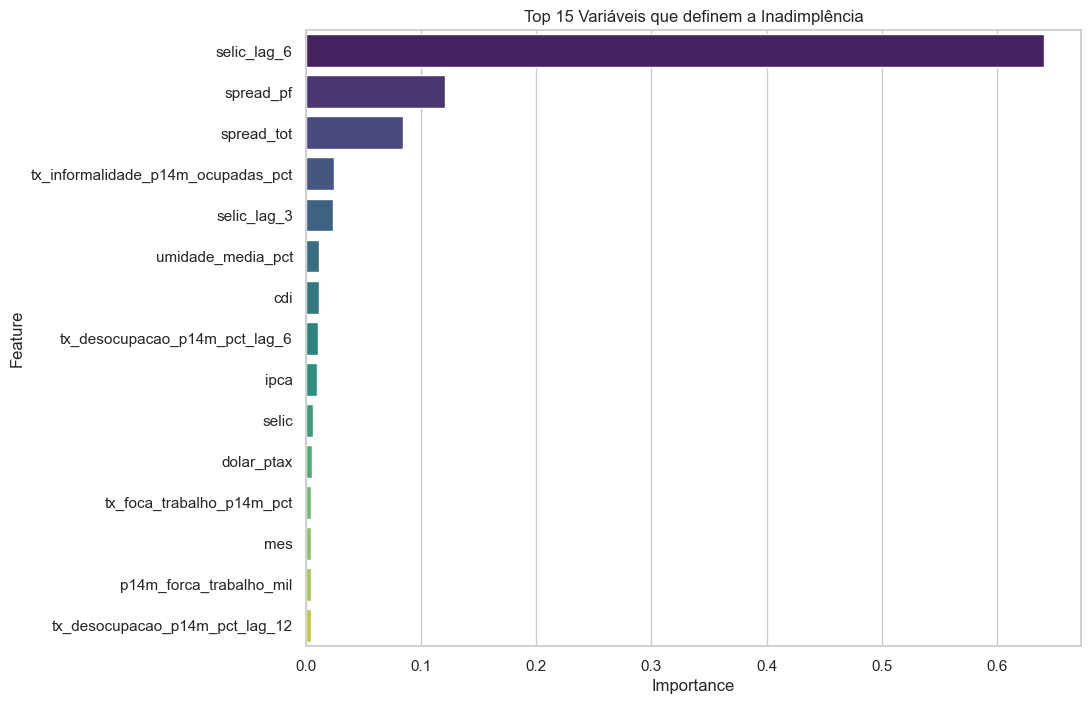

In [5]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Variáveis que definem a Inadimplência")
plt.show()

# Modelo Otimizado (Autoregressivo)
A melhor forma de prever o amanhã é olhar para o hoje. A inadimplência tem inércia (quem não pagou mês passado, provavelmente continua devendo este mês). Vamos adicionar a coluna target_lag_1 (Inadimplência do mês anterior) como variável explicativa.

--- MODELO CAMPEÃO: AUTOREGRESSIVO ---
Removendo colunas de vazamento (Leakage): ['inad_pj_tot', 'inad_pf_tot', 'inad_rd_pf_cr_rur_tot', 'inad_rd_pj_cr_rur_tot']
Novo RMSE: 0.0896
Novo R2: -0.4338


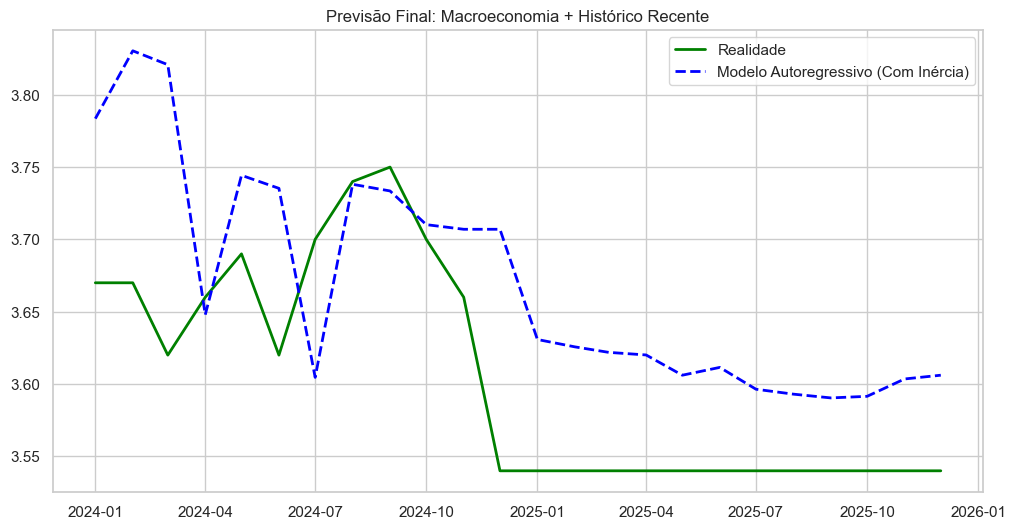

In [6]:
print("--- MODELO CAMPEÃO: AUTOREGRESSIVO ---")

# 1. Criar a feature de Lag no Dataset Original
df_auto = df.copy()

# Criar a variável do passado (Isso é o que dá "inércia" ao modelo)
df_auto["inad_anterior"] = df_auto[target].shift(1)
df_auto = df_auto.dropna()

# 2. Refazer X e y
cols_leakage_auto = [c for c in df_auto.columns if c.startswith("inad_") and c != "inad_anterior"]
print(f"Removendo colunas de vazamento (Leakage): {cols_leakage_auto}")

X_auto = df_auto.drop(columns=cols_leakage_auto)
y_auto = df_auto[target]

# Garantia de Dummies
X_auto = pd.get_dummies(X_auto, drop_first=True)

# 3. Split (80/20 Cronológico)
train_size_a = int(len(df_auto) * 0.80)
X_train_a, X_test_a = X_auto.iloc[:train_size_a], X_auto.iloc[train_size_a:]
y_train_a, y_test_a = y_auto.iloc[:train_size_a], y_auto.iloc[train_size_a:]

# 4. Scale
scaler_a = StandardScaler()
X_train_a_sc = scaler_a.fit_transform(X_train_a)
X_test_a_sc = scaler_a.transform(X_test_a)

# 5. Treinar
model_autoregressivo = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)
model_autoregressivo.fit(X_train_a_sc, y_train_a)

# 6. Avaliar
y_pred_a = model_autoregressivo.predict(X_test_a_sc)
rmse_a = np.sqrt(mean_squared_error(y_test_a, y_pred_a))
r2_a = r2_score(y_test_a, y_pred_a)

print(f"Novo RMSE: {rmse_a:.4f}")
print(f"Novo R2: {r2_a:.4f}")

# Plot Comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_a.index, y_test_a, label="Realidade", color="green", linewidth=2)
plt.plot(y_test_a.index, y_pred_a, label="Modelo Autoregressivo (Com Inércia)", color="blue", linestyle="--", linewidth=2)
plt.title("Previsão Final: Macroeconomia + Histórico Recente")
plt.legend()
plt.show()

# Salvando os Artefatos

In [7]:
# Criar pasta models se não existir
path_models = Path("../models/")
path_models.mkdir(parents=True, exist_ok=True)

# 1. Salvar Modelo
joblib.dump(model_autoregressivo, path_models / "model_autorregressivo.pkl")

# 2. Salvar Scaler
joblib.dump(scaler_a, path_models / "scaler_autorregressivo.pkl")

# 3. Salvar Amostra de Treino
X_train_a.to_csv(path_models / "X_train_columns_autorregressivo.csv", index=False)

print("Tudo pronto! Modelos salvos em ../models/")

Tudo pronto! Modelos salvos em ../models/
